Epoch 1/100
8/8 [==============================] - 6s 24ms/step - loss: 0.2297
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0679
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0446
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0491
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0424
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0420
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0407
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0402
Epoch 9/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0393
Epoch 10/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0390
Epoch 11/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0383
Epoch 12/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0383
Epoch 13/100
8/8 [==============================]

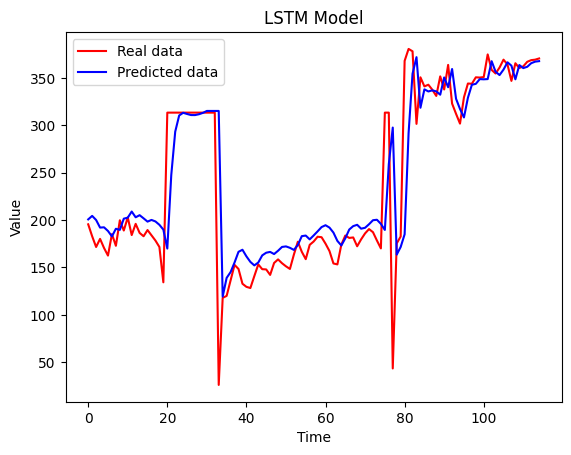

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 加载数据
data = pd.read_excel('./副本2022送电量.xlsx',sheet_name='Sheet2')
#根据时间排序
data = data.sort_values(by='date')
# 将date列转换成 Datetime 类型，并将其设置为索引列
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 计算去零后的均值
mean_value = data.loc[data['value'] != 0, 'value'].mean()
# 将0替换为去零后的均值
data['value'] = data['value'].replace(0, mean_value)
train_set = data.iloc[:250, 0:1].values
test_set = data.iloc[250:, 0:1].values

# 数据归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set)

# 创建训练集数据和标签
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 10
X_train, y_train = create_dataset(train_set_scaled, look_back)

# 调整输入数据的形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32)

# 进行预测
inputs = data[len(data) - len(test_set) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)



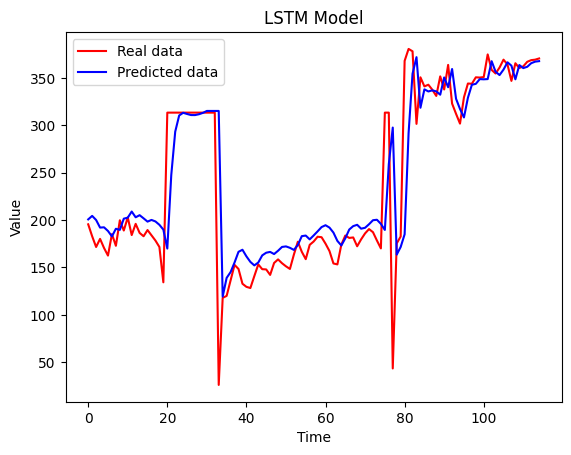

In [5]:
# 绘制预测结果，x轴为对应的时间
import matplotlib.pyplot as plt
plt.plot(test_set, color='red', label='Real data')
plt.plot(predicted, color='blue', label='Predicted data')
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
